In [1]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy import signal
from scipy.signal import argrelextrema, medfilt
import time, os
from datetime import datetime

In [2]:
# Выбор порта данных с катушек
ports = serial.tools.list_ports.comports()
port = None
# print(ports)
for i, port in enumerate(ports):
    # print(f"{port}")
    print(f"Порт {i}: {port.device}")
    # print(f"Описание: {port.description}")
    # print(f"VID:PID: {port.vid}:{port.pid}")
if port:
    # prt = int(input('Какой порт?'))
    port = ports[0].device
    port_motor = ports[1].device
    print(f'Для получения данных выбран порт - {port}')
    print(f'Для двигателя выбран порт - {port_motor}')

Порт 0: COM6
Порт 1: COM7
Для получения данных выбран порт - COM6
Для двигателя выбран порт - COM7


In [ ]:
# Отправка команды на вращение магнита
with (serial.Serial(port_motor, baudrate=57600, bytesize=8, parity='N', stopbits=1, timeout=0)) as serialData:
    # Read data from COM port
    revolutions = 26
    distance=1000/9
    speed=100
    command = f'ON\rMOVE L(-{int(revolutions * distance)})F({int(speed)})\rOFF\r'
    serialData.write(command.encode(encoding="utf-8"))

In [4]:
# Чтение данных с катушек в память контроллера
time.sleep(5)
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=11)) as serialData:
    # Read data from COM port
    command = 'R'

    # Send the command to the DataPort
    serialData.write(command.encode(encoding="utf-8"))
    # serialline.flush()
time.sleep(11)

# Получение данных с выбранного порта в память компьютера
rawdata = None
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=47)) as serialData:
    # Read data from COM port
    command = 'S'

    # Send the command to the DataPort
    serialData.write(command.encode())
    
    # Get data
    rawdata = serialData.read(4194305)

In [5]:
rawdata[-55:-1]

b'\x0eb\x0eb\x0eb\x0eb\x0eb\x0ec\x0ec\x0ec\x0ec\x0ec\x0ed\x0ed\x0ed\x0ed\x0ed\x0ee\x0ee\x0ee\x0ee\x0ee\x0ee\x0ef\x0ef\x0ef\x0ef\x0ef\x0eg'

In [6]:
# Перевод данных из битов в целые числа
data = []
for num in range(0, 2097152, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    data.append(hi_byte*256+lo_byte)

encoder = []
for num in range(2097152, len(rawdata)-1, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    encoder.append(hi_byte*256+lo_byte)
df_raw = pd.DataFrame({'encoder' : encoder, 'data' : data})

In [8]:
# Запись данных в файл
try:
    os.mkdir('data')
except FileExistsError:
    pass
except Exception as e:
    print(f'Что-то пошло не так: {e}')

filename = f"data_123raw_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
dir = 'data'

df_raw.to_csv(os.path.join(dir, filename))

<Axes: >

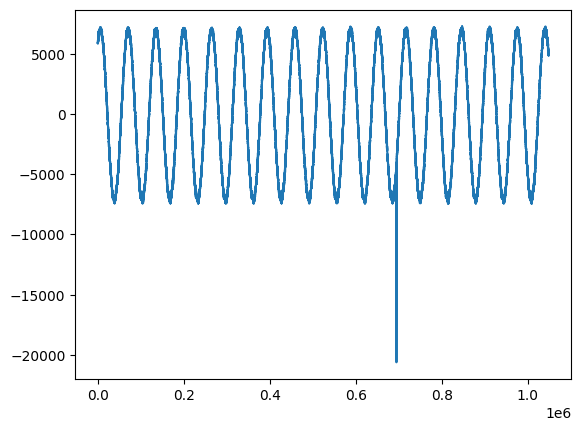

In [2]:
df_raw = pd.read_csv(os.path.join('..', 'data','data_raw.csv'), index_col=0)
%matplotlib inline
df_raw.data.plot()
# df_raw.encoder.plot()

In [8]:
# import scipy
# Применяем медианный фильтр из scipy
window_size = 3
df_filtered = pd.DataFrame(columns=['data', 'encoder'])
df_filtered.data = medfilt(df_raw.data, kernel_size=window_size)[window_size*2:-window_size*2]
df_filtered.encoder = medfilt(df_raw.encoder, kernel_size=window_size)[window_size*2:-window_size*2]

# df_filtered = df_raw.copy()

In [9]:
# Отрезаем целое число периодов

split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]
start_idx = split_points[0]
end_idx = split_points[-1]
df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

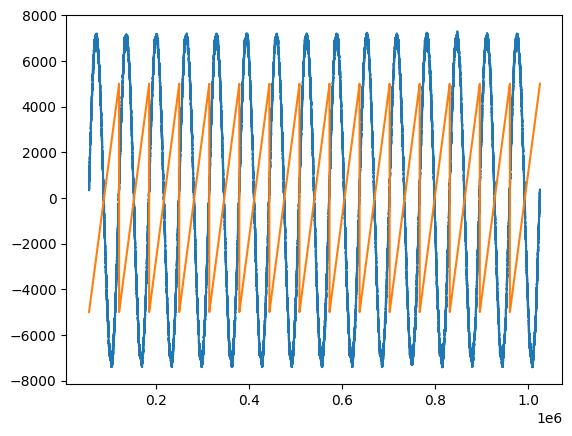

In [12]:
%matplotlib inline
# plt.plot(df_filtered.data)
plt.plot(df_trimmed.data)
# plt.plot((df_filtered.encoder-5000)/1)
plt.plot(df_trimmed.encoder-5000)

df = df_trimmed.copy()

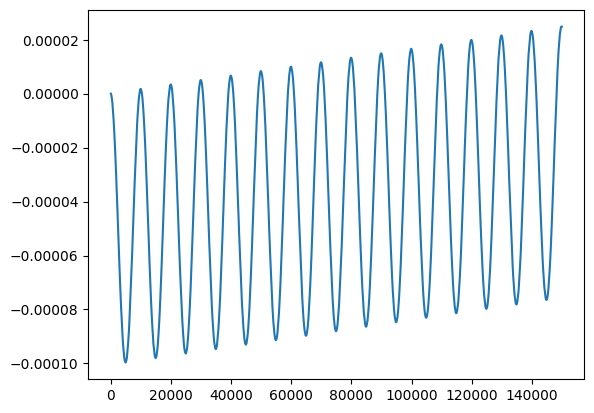

In [13]:
# Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных

# Добавим столбец, который идентифицирует периоды непрерывных значений encoder
df['period'] = (df['encoder'] != df['encoder'].shift()).cumsum()

# Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
result = df.groupby('period').agg({'data': 'sum', 'encoder': 'max'}).reset_index().drop('period', axis=1)

result['integral'] = -1.0*result.data.cumsum()

# 2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
result['volts'] = -(2.5/32767 * 1/96937 * 1/1144.8)*result.data.cumsum()

result['deg'] = result.index/10000*360

result
%matplotlib inline
plt.plot(result.volts)


In [19]:
import fastgoertzel as fg

amp, phase = fg.goertzel(result.volts.values, 1/10000)
# phase = phase*180/np.pi
print(f'Goertzel Amp: {amp:}, {phase = :}')

Goertzel Amp: 5.0312589020050334e-05, phase = 0.07984959818108946


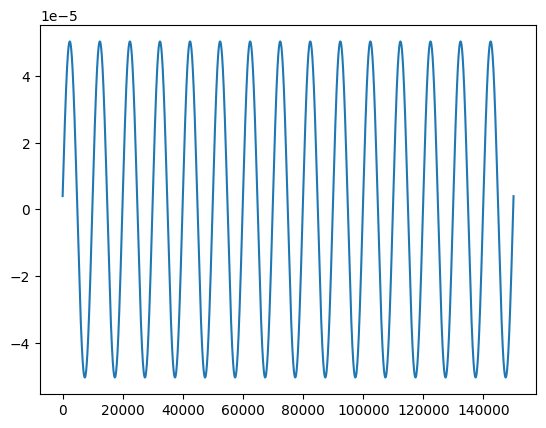

In [20]:
x = result.index.values
y = amp * np.sin(2*np.pi * 1/10000 * x + phase)

plt.plot(x, y)

In [37]:
# Шаг интегрирования по encoder
step = 25
# Создание интервалов
bins = range(0, len(df_filtered) + step, step)

# Находим индексы, где происходит переход с 9999 на 0
# split_points = df_filtered.index[(df_filtered['encoder'].shift(1) == 9999) & (df_filtered['encoder'] == 0)]
split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]

# Добавляем начало и конец датасета
# split_points = [0] + split_points.tolist() + [len(df_filtered)]
# split_points = split_points.tolist()

# Создаем список разделенных датафреймов с группировкой по encoder
datasets = []
for i in range(len(split_points) - 1):
    start_idx = split_points[i]
    end_idx = split_points[i+1]
    dataset_part = df_filtered.iloc[start_idx:end_idx].copy()
    dataset_part.encoder = dataset_part.encoder + 10000 * i

    # Группировка по encoder и усреднение data
    dataset_part['bin'] = pd.cut(dataset_part['encoder'], bins=bins, right=False, labels=bins[:-1])
    grouped = dataset_part.groupby('bin', observed=True)['data'].sum()
    
    datasets.append(grouped)

df_encoder = pd.concat(datasets).reset_index()
df_encoder['integrated_data'] = -(2.5/32767 * 1/96937)*df_encoder['data'].cumsum() # 2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase) минус из формулы интегрирования

# -(2.5/32767 * 1/96937)*

# x = df_encoder.integrated_data.index.values
# y = df_encoder.integrated_data.values

# # Линейная регрессия для выделения тренда
# coefficients = np.polyfit(x, y, 1)  # 1 - линейный тренд
# df_encoder['trend1'] = np.polyval(coefficients, x)

# Убедимся, что индекс — это просто последовательные целые числа (0, 1, 2, ..., N-1)
x_tr = np.arange(len(df_encoder.integrated_data))
y_tr = df_encoder.integrated_data.values

# Координаты первой и последней точек
x0, x1 = x_tr[0], x_tr[-1]
y0, y1 = y_tr[0], y_tr[-1]

# Уравнение прямой через две точки: y_trend = a * x + b
a = (y1 - y0) / (x1 - x0) if x1 != x0 else 0
b = y0 - a * x0

# Вычисляем тренд
df_encoder['trend'] = a * x + b

# Детрендированные данные
# df_encoder['data1'] = (df_encoder.integrated_data - df_encoder.trend1) / 1144.8 
df_encoder['data'] = (df_encoder.integrated_data - df_encoder.trend) / 1144.8 # 1144.8 - Постоянная катушки [1/м]
df_encoder['deg'] = df_encoder.index/10000/step*360

df = df_encoder.reindex(columns=['deg', 'data'])
df

,deg,data
0,0.00000,0.000000e+00
1,0.00144,-7.667057e-08
2,0.00288,-1.444721e-07
3,0.00432,-2.350533e-07
4,0.00576,-4.047368e-07
...,...,...
5995,8.63280,9.003431e-08
5996,8.63424,7.689935e-08
5997,8.63568,5.582356e-08
5998,8.63712,3.267147e-08


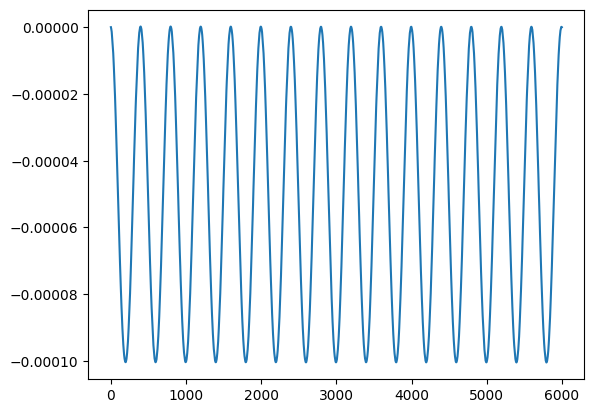

In [38]:
plt.plot(df['data'])
# plt.plot(df_encoder['trend1'])
# plt.plot(df_encoder['trend2'])

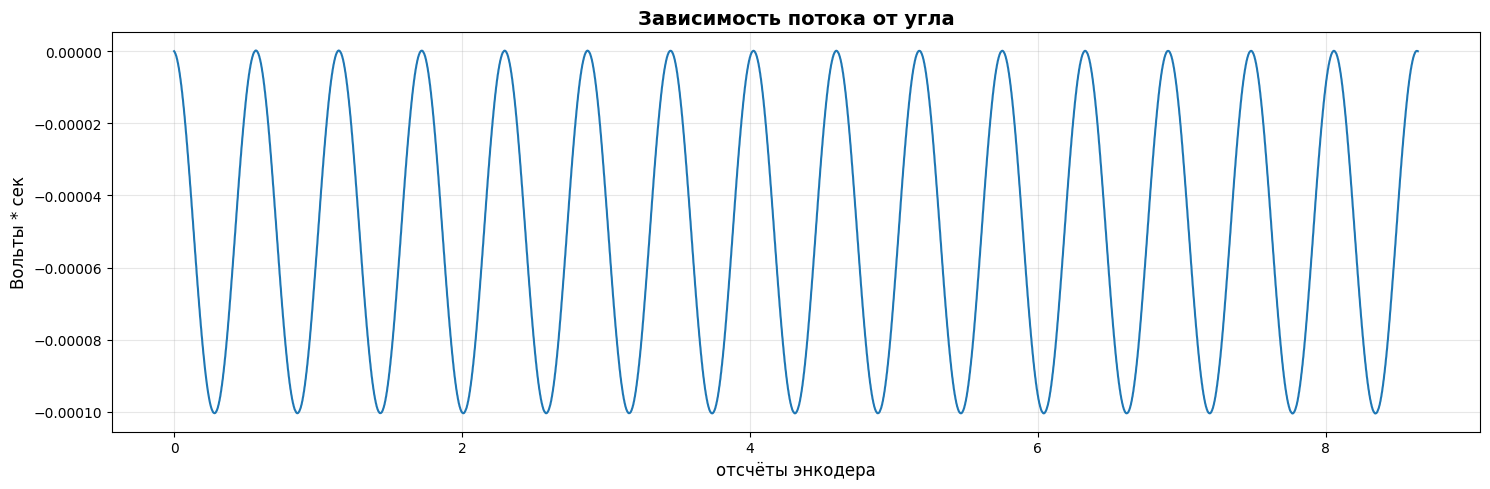

In [39]:
%matplotlib inline
# Создаем график с настройками
plt.figure(figsize=(15, 5))
# Добавляем заголовок и подписи осей
plt.title("Зависимость потока от угла", fontsize=14, fontweight='bold')
plt.xlabel("отсчёты энкодера", fontsize=12)
plt.ylabel("Вольты * сек", fontsize=12)

plt.grid(True, alpha=0.3) # Улучшаем сетку

# plt.scatter(df.deg, df.data, alpha=0.7, s=20, color='red')
plt.plot(df.deg, df.data)

# Показываем график
plt.tight_layout()
plt.show()

In [40]:
# Локальные максимумы
local_maxima = argrelextrema(df.data.values, np.greater, order=100)[0]
# Локальные минимумы
local_minima = argrelextrema(df.data.values, np.less, order=100)[0]

print(f"Найдено локальных максимумов: {len(local_maxima)}")
print(f"Найдено локальных минимумов: {len(local_minima)}")

# Добавляем метки в DataFrame
df['is_local_max'] = False
df['is_local_min'] = False

df.loc[local_maxima, 'is_local_max'] = True
df.loc[local_minima, 'is_local_min'] = True

# # Создаем столбец с типом экстремума
# df['extrema_type'] = 'none'
# df.loc[local_maxima, 'extrema_type'] = 'max'
# df.loc[local_minima, 'extrema_type'] = 'min'

df

Найдено локальных максимумов: 15
Найдено локальных минимумов: 15


,deg,data,is_local_max,is_local_min
0,0.00000,0.000000e+00,False,False
1,0.00144,-7.667057e-08,False,False
2,0.00288,-1.444721e-07,False,False
3,0.00432,-2.350533e-07,False,False
4,0.00576,-4.047368e-07,False,False
...,...,...,...,...
5995,8.63280,9.003431e-08,True,False
5996,8.63424,7.689935e-08,False,False
5997,8.63568,5.582356e-08,False,False
5998,8.63712,3.267147e-08,False,False


In [96]:
filename = f"data_31_int_peaks_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
dir = 'data'

df.to_csv(os.path.join(dir, filename))

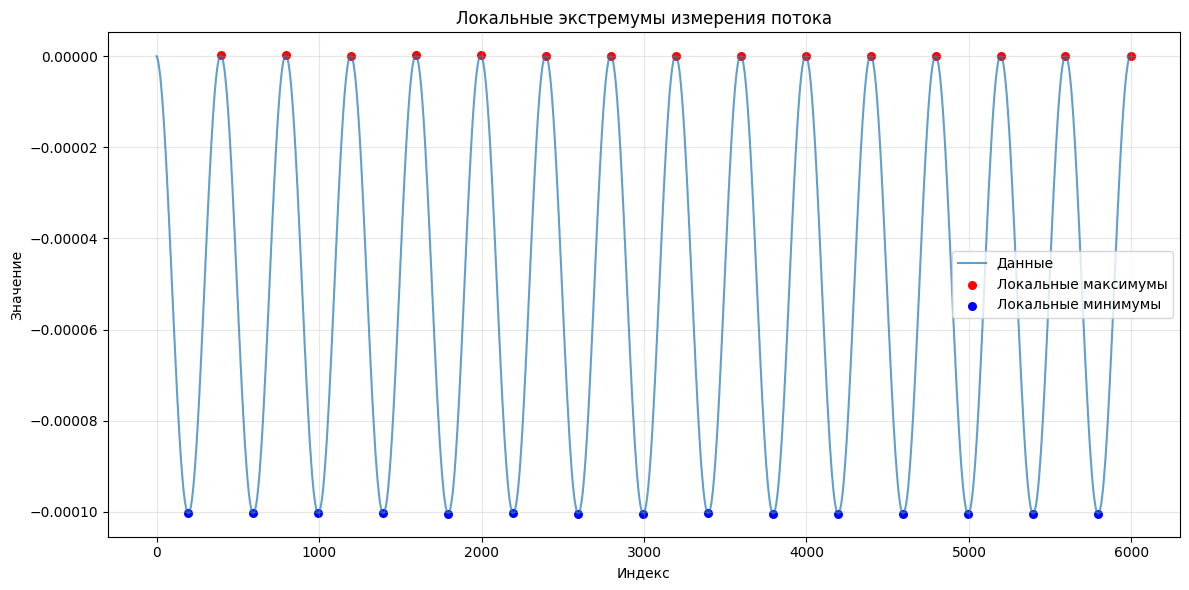

In [41]:
%matplotlib inline
data_column = 'data'

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[data_column], label='Данные', alpha=0.7)
plt.scatter(local_maxima, df.loc[local_maxima, data_column], 
           color='red', label='Локальные максимумы', s=30)
plt.scatter(local_minima, df.loc[local_minima, data_column], 
           color='blue', label='Локальные минимумы', s=30)
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('Локальные экстремумы измерения потока')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('extrema_plot.png', dpi=300)
plt.show()

In [43]:
data = 'data'

# Извлечение экстремумов
maxima = df[df['is_local_max']]
minima = df[df['is_local_min']]

# Вычисляем средние значения
mean_max = maxima[data].mean()
mean_min = minima[data].mean()

# Разность средних
amplitude = (mean_max - mean_min)/2

# 3. Вычисляем погрешности
# Погрешность среднего значения максимумов
std_max = maxima[data].std(ddof=1)
std_error_max = std_max / np.sqrt(len(maxima))

# Погрешность среднего значения минимумов
std_min = minima[data].std(ddof=1)
std_error_min = std_min / np.sqrt(len(minima))

# Абсолютная погрешность амплитуды (по формуле погрешности разности)
absolute_error = np.sqrt(std_error_max**2 + std_error_min**2) / 2

# Относительная погрешность амплитуды
relative_error = absolute_error / amplitude * 100  # в процентах

print(f"   Амплитуда = {amplitude:.3} ± {absolute_error:.2}")
print(f"   Относительная погрешность: {relative_error:.4f}%")
f'{amplitude:}'

   Амплитуда = 5.03e-05 ± 5.6e-09
   Относительная погрешность: 0.0112%


'5.0267016615903564e-05'